# Setup

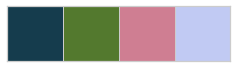

In [8]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import pickle
import joblib
from __future__ import division
from IPython.display import display

# set styling for plots
%matplotlib inline  
sns.set(style = "whitegrid")
sns.set_palette('cubehelix',4)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sns.palplot(sns.color_palette())

# define names of models
clfs = ["LogitNonLinear","RandomForestIsotonic"]
outnames = {"LogitNonLinear": "Nonlinear Logit","RandomForestIsotonic" : "Random Forest","xgboost_output": "XGBoost","Difference" : "Difference"}

# set race categories for plots
plotrace = ["Asian","White Non-Hispanic","White Hispanic","Black"]

# Load and clean data

In [9]:
# set paths to saved data
path = '../../data/' 

# load main dataset 
allvals = pd.read_csv(path + 'all_vals_race1_interestrate1.csv',index_col=0)

# load predictions 
preds00 = pd.read_csv(path + '../output/_race0_interestrate0.csv',index_col=0) 

# load saved classifiers and save feature names
clfpath = '../../output/'
models = {}; features = {}
for name in clfs:
    if name.startswith('Logit'):
        models[name] = pickle.load(open(clfpath + name + "_race0_interestrate0.pkl",'rb'))
        features[name] = list(models[name].params.index)
    else:
        models[name] = joblib.load(open(clfpath + name + "_race0_interestrate0.pkl",'rb'))
        features[name] = [x.lower() for x in list(pd.read_csv(path + 'feature_names_norace' + name + '.csv').columns)]
features['RandomForestIsotonic'].remove('sato')

In [10]:
# clean race variable in main data
racecols = [col for col in list(allvals) if col.startswith('race_dum')]
allvals["White Non-Hispanic"] = 1 -  allvals[racecols].sum(axis=1)
allvals["Race"] = allvals[racecols + ["White Non-Hispanic"]].idxmax(axis=1).str.replace('race_dum_','').replace('White hisp','White Hispanic')

In [11]:
# merge main data and predictions 
#df0 = allvals.drop(['LogitNonLinear','RandomForest','RandomForestIsotonic'], axis="columns")
df0 = allvals
df0 = df0.join(preds00)

# Figure 4: Example heatmaps

In [12]:
# utility for adding fico, ltv and income bins used by logit to a dataframe
def mkbins(df):
    bins = pd.DataFrame(index = df.index)

    fico_cuts = [0] + list(range(280,870,20))
    fico_bin = pd.cut(df["fico_orig_fill"], fico_cuts, labels = fico_cuts[0:-1], right = False).fillna(0)
    fico_bin.loc[(fico_bin>0) & (fico_bin < 600),] = 600
    fico_bin.loc[fico_bin==840,] = 820

    ltv_cuts = list(range(20,110,5))
    ltv_bin = pd.cut(df["ltv_ratio_fill"], ltv_cuts, labels = ltv_cuts[0:-1], right = False)
    ltv_80 = (df["ltv_ratio_fill"]==80.0).astype(int)    

    inc_cuts = list(range(-25,550,25))
    income_bin = pd.cut(df["applicant_income"],inc_cuts, labels = inc_cuts[0:-1],right = False)

    bins = bins.join(pd.get_dummies(fico_bin, prefix = "fico_bin_dum"))
    bins = bins.join(pd.get_dummies(income_bin, prefix = "income_bin_dum"))
    bins = bins.join(pd.get_dummies(ltv_bin, prefix = "ltv_bin_dum"))
    bins["ltv_80_dum_0"] = 1 - ltv_80
    bins['const'] = 1
    return bins

In [13]:
# make predictions on fico/income grid in figure

# grid of income / fico
inc_grid = np.linspace(20,200,50)
fic_grid = np.linspace(650,820,50)
inc_list = [x for x in inc_grid for y in fic_grid]
fic_list = [y for x in inc_grid for y in fic_grid]

# set up grid
G = len(inc_grid)*len(fic_grid)
K = len(features["RandomForestIsotonic"])
x = pd.DataFrame(np.zeros((G,K)),columns = features["RandomForestIsotonic"])

# insert income/fico grids
x["applicant_income"]=inc_list
x["fico_orig_fill"]=fic_list

# hard code the remaining variables as explained in paper 
ltv = 79.99 # exactly 80 doesn't work
amt = 300000
x["ltv_ratio_fill"] = ltv
x["orig_amt"]=amt 
x["log_orig_amt"]=np.log(amt)
# x["sato"] = 0
x["occupancy_type_dum_1"]= 1
x["investor_type_dum_2"] = 1
x["loan_purpose_dum_1"] = 1
x["orig_year_dum_2011"] = 1
x["prop_state_dum_CA"] = 1
x["prop_state_dum_TX"] = 0
x["cur_int_rate"] = 4.5

xbins = mkbins(x)
x = x.join(xbins)

# predictions for PD contour plot 
pred = pd.DataFrame(index = x.index, columns = clfs)
for name in clfs:
    if name.startswith('Logit'): 
        pred[name] = models[name].predict(x[features[name]]) 
    else:
        pred[name] = models[name].predict_proba(x[features[name]])[:,1]
        
# get group densities on grid
race = df0['Race']
inc_grid1 = np.linspace(20,200,10)
fic_grid1 = np.linspace(650,820,10)
heat = pd.DataFrame(index = allvals.index, columns = ["Income","FICO","Minority"])
heat["Income"] = pd.cut(allvals["applicant_income"],inc_grid1,labels = inc_grid1[1:].astype('int'))
heat["FICO"] = pd.cut(allvals["fico_orig_fill"],fic_grid1,labels = fic_grid1[1:].astype('int'))
# heat["Minority"] = ((race == "Black") | (race == "White Hispanic")).astype('int')
heat["Minority"] = (race == "Black").astype('int')
heat["Majority"] = (race == "White Non-Hispanic").astype('int')
inrange = heat["Income"].notnull() & heat["FICO"].notnull()
heat = heat[inrange]
piv = {}
piv['Black'] = pd.pivot_table(data = heat, index = "FICO", columns = "Income"
                            , values = "Minority", fill_value = 0,
                            aggfunc = (lambda x: x.sum()/heat["Minority"].sum()))
piv['White Non-Hispanic'] = pd.pivot_table(data = heat, index = "FICO", columns = "Income"
                            , values = "Majority", fill_value = 0,
                            aggfunc = (lambda x: x.sum()/heat["Majority"].sum()))

# draw contour plots
X,Y = np.meshgrid(inc_grid,fic_grid)
fig,ax = plt.subplots(2,len(clfs),figsize = (10,8))
ext = [inc_grid1.min(),inc_grid1.max(), 
       fic_grid1.min(),fic_grid1.max()]
cvals = [[0.1,0.2,0.3,0.5],[0.2,0.3,0.6,1,1.3,1.6]]
for (i,name) in enumerate(clfs):
    for (j,g) in enumerate(piv.keys()[::-1]):
        # dist for group j
        ax[i,j].imshow(piv[g][::-1],cmap="Purples",extent = ext,alpha = 0.6)
        
        # contour for clf i overlaid
        Z = pred[name].values.reshape(X.shape)
       
        CS = ax[i,j].contour(X,Y,100*Z,cvals[i],cmap=None,colors='k')
        plt.clabel(CS, fontsize=14,inline=True,fmt='%1.1f')
        
#         ax[i,0].set_ylabel('%s' % (outnames[name]),fontsize=18)
        ax[i,j].set_xlabel('Income',fontsize = 14)
        ax[i,j].set_ylabel('FICO',fontsize = 14)


        ax[i,j].set_title('%s: %s' % (outnames[name],g),fontsize=15)


        ax[i,j].grid(False)
        ax[i,j].tick_params(labelsize = 16)


plt.tight_layout(pad=1)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished


KeyboardInterrupt: 

# Figure 5: CDFs

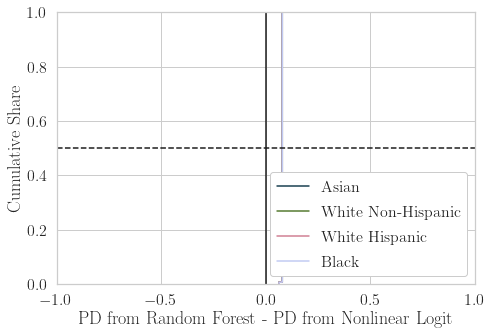

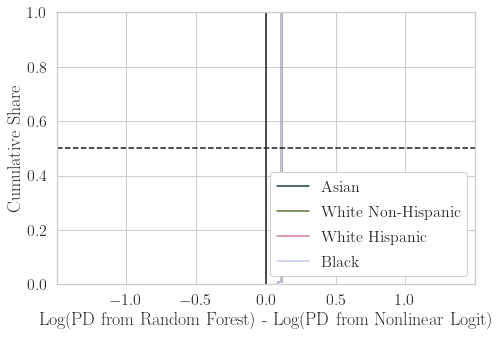

In [14]:
# utility for making cdf plots (diff of level or log PD)
def cdf_pd_diff(df,race,plotrace,clfs,lim = (-1,1),log=False):
    fig, ax = plt.subplots(1,1,figsize=(7.5,5))
    if log:
        diff = df[clfs[1]].apply(np.log) - df[clfs[0]].apply(np.log)
        factor = 1
    else:
        diff = df[clfs[1]] - df[clfs[0]]
        factor = 100
    for group in plotrace:
        x = np.sort(factor*(diff[race==group]))
        y = np.linspace(1,x.shape[0],x.shape[0]) / x.shape[0]
        ax.plot(x,y,label=group)
    ax.set_xlim(lim); ax.set_ylim((0,1))
    ax.set_xticks([-1,-0.5,0,0.5,1])
#     ax.set_yticks([0,0.25,0.5,0.75,1])
    ax.axvline(0,color='k')
    ax.axhline(0.5,color='k',linestyle='--')
    plt.xticks(fontsize=16); plt.yticks(fontsize = 16)
    if log: 
        ax.set_xlabel('Log(PD from %s) - Log(PD from %s)' %(outnames[clfs[1]],outnames[clfs[0]]),fontsize = 18)
    else:
        ax.set_xlabel('PD from %s - PD from %s' %(outnames[clfs[1]],outnames[clfs[0]]),fontsize = 18)
    ax.set_ylabel('Cumulative Share',fontsize=18)
    ax.legend(frameon=True,framealpha=1,fontsize = 16,loc='lower right')

# make figures
race = df0['Race']
cdf_pd_diff(df0,race,plotrace,clfs,lim = (-1,1),log=False)
cdf_pd_diff(df0,race,plotrace,clfs,lim = (-1.5,1.5),log=True)

# Table VI: Decomposition

In [15]:
# import scores
score00 = pd.read_csv(path + '../output/eval_output_race0_interestrate0.csv',index_col=0)
score10 = pd.read_csv(path + '../output/eval_output_race1_interestrate0.csv',index_col=0)
display(score00)
display(score10)

# decompositions using saved scores
x_part = score00.loc[clfs[0]] - score00.loc[clfs[1]]
total = score00.loc[clfs[0]] - score10.loc[clfs[1]]
g_part = score00.loc[clfs[0]] - score10.loc[clfs[0]]

racefirst = (100*pd.DataFrame({"Race": g_part / total, "Technology": 1 - g_part/ total})).astype('float').round(2)

techfirst = (100*pd.DataFrame({"Technology": x_part/ total , "Race": 1 - x_part / total})).astype('float').round(2)
techfirst = techfirst[["Technology","Race"]]

print('adding race first')
display(racefirst)
print('adding technology first')
display(techfirst)

,roc,precision,brier_score
model,,,
Logit,0.498538,0.007465,0.007415
LogitNonLinear,0.501351,0.007496,0.007415
RandomForest,0.498721,0.007448,0.007451
RandomForestIsotonic,0.499342,0.007448,0.007415


,roc,precision,brier_score
model,,,
Logit,0.500043,0.007489,0.007415
LogitNonLinear,0.501351,0.007496,0.007415
RandomForest,0.497118,0.007426,0.007454
RandomForestIsotonic,0.499291,0.007463,0.007415


adding race first


,Race,Technology
roc,0.0,100.0
precision,0.0,100.0
brier_score,0.0,100.0


adding technology first


,Technology,Race
roc,97.52,2.48
precision,146.89,-46.89
brier_score,100.37,-0.37
